# Project 1

In [1]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import sys
import networkx as nx
import pandas
from math import lgamma

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
smallDf = pandas.read_csv('small.csv')

In [3]:
list(smallDf)

['age',
 'portembarked',
 'fare',
 'numparentschildren',
 'passengerclass',
 'sex',
 'numsiblings',
 'survived']

In [31]:
def initialize(df):
    headers = list(df)
    g = nx.DiGraph()
    for header in headers:
        inst_vals = df[header].unique()
        instantiations = np.max(inst_vals)
        g.add_node(header, inst=instantiations)
    return g

def bayes_score(g, df):
    num_rows = len(df)
    nodes = g.nodes(data=True)
    score = 0
    for n,d in nodes:
        r_i = d['inst']
        parents = list(g.predecessors(n))
        parent_score = 0
        if (len(parents) > 0):
            parent_insts = df.groupby(parents).size().reset_index(name='counts')
            for p in parent_insts.counts:
                parent_score += lgamma(r_i) - lgamma(r_i + p)
        else:
            parent_score = lgamma(r_i) - lgamma(r_i + num_rows)

        child_list = [n] + parents
        child_insts = df.groupby(child_list).size().reset_index(name='counts')
        child_score = 0
        for c in child_insts.counts:
            child_score += lgamma(1 + c) - lgamma(1)
        score += parent_score + child_score
    return round(score, 5)

def local_search(init_g, df, iters=2, plimit=5, debug=False):
    graph = init_g.copy()
    best_score = bayes_score(graph, df)
    for i in range(iters):
        for n in graph.nodes():
            for p in graph.nodes():
                if (n == p or len(list(graph.predecessors(n))) >= plimit):
                    continue
                # try removing edge
                if (graph.has_edge(p, n)):
                    if (debug):
                        bscore = bayes_score(graph, df)
                    best_score, success = test_fitness(graph.remove_edge, graph.add_edge, n, p, graph, df, best_score, debug)
                    if (debug):
                        ascore = bayes_score(graph, df)
                        action = "rem"
                        print(i, ":", action, "new best", best_score, "before", bscore, "after", ascore, success, '\n')
                    
                    # if removing wasn't better, try reversing
                    if (graph.has_edge(p, n)):
                        if (debug):
                            bscore = bayes_score(graph, df)
                        best_score, success = test_fitness(reverse_edge(graph), reverse_edge(graph), n, p, graph, df, best_score, debug)
                        if (debug):
                            ascore = bayes_score(graph, df)
                            action = "rev"
                            print(i, ":", action, "new best", best_score, "before", bscore, "after", ascore, success, '\n')

                else: # try adding edge
                    if (debug):
                        bscore = bayes_score(graph, df)
                    best_score, success = test_fitness(graph.add_edge, graph.remove_edge, n, p, graph, df, best_score, debug)
                    if (debug):
                        ascore = bayes_score(graph, df)
                        action = "add"
                        print(i, ":", action, "new best", best_score, "before", bscore, "after", ascore, success, '\n')

    return graph, best_score


def test_fitness(fn, fnrev, n, p, g, df, best_score, debug=False):
    if (debug):
        print('score_before', best_score)
    fn(p, n)
    score = bayes_score(g, df)
    if (debug):
        print('score_after', score)
    success = True

    if (score <= best_score or has_cycle(g)):
        fnrev(p, n)
        score = best_score
        success = False
        if (debug):
            print('score_after reversing', bayes_score(g, df))
        if (best_score != bayes_score(g, df)):
            print('SOMETHING IS VERY WRONG')

    return score, success

def reverse_edge(graph):
    def rev_with_g(parent, child):
        if (graph.has_edge(parent, child)):
            graph.remove_edge(parent, child)
            graph.add_edge(child, parent)

        if (graph.has_edge(child, parent)):
            graph.remove_edge(child, parent)
            graph.add_edge(parent, child)
    return rev_with_g


def has_cycle(g):
    cycle = False
    try:
        cycle = len(nx.algorithms.cycles.find_cycle(g)) > 0
    except:
        pass
    return cycle

def write_gph(dag, filename):
    with open(filename, 'w') as f:
        for edge in dag.edges():
            f.write("{}, {}\n".format(edge[0], edge[1]))

-4166.22586
-3826.31218
-3826.31218


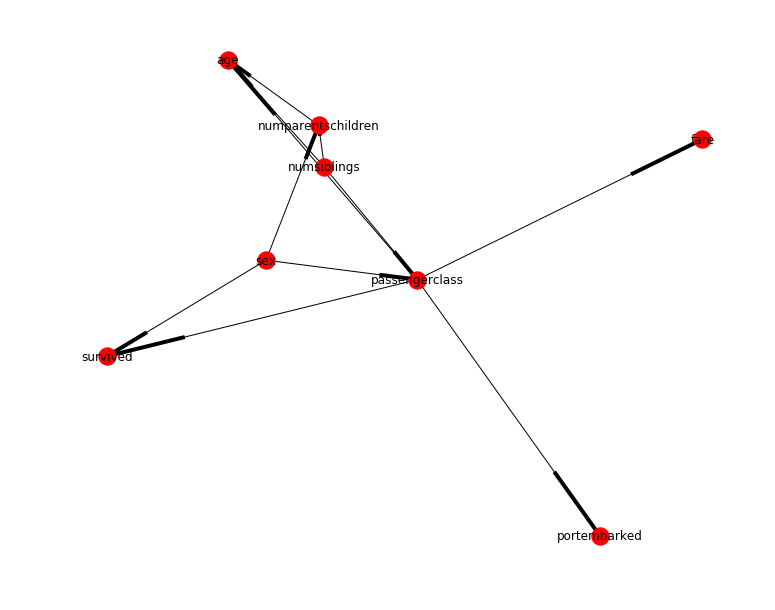

In [35]:
sg = initialize(smallDf)
print(bayes_score(sg, smallDf))

osg, best_score = local_search(sg, smallDf, iters=2, debug=False)

print(best_score)
print(bayes_score(osg, smallDf))

nx.draw(osg, with_labels=True)
plt.show()

In [ ]:
sg = initialize(smallDf)
print(bayes_score(sg, smallDf))

osg, best_score = local_search(sg, smallDf, plimit=10000)

print(best_score)
print(bayes_score(osg, smallDf))

nx.draw(osg, with_labels=True)
plt.show()

-45388.95843
-42561.09697
-42561.09697


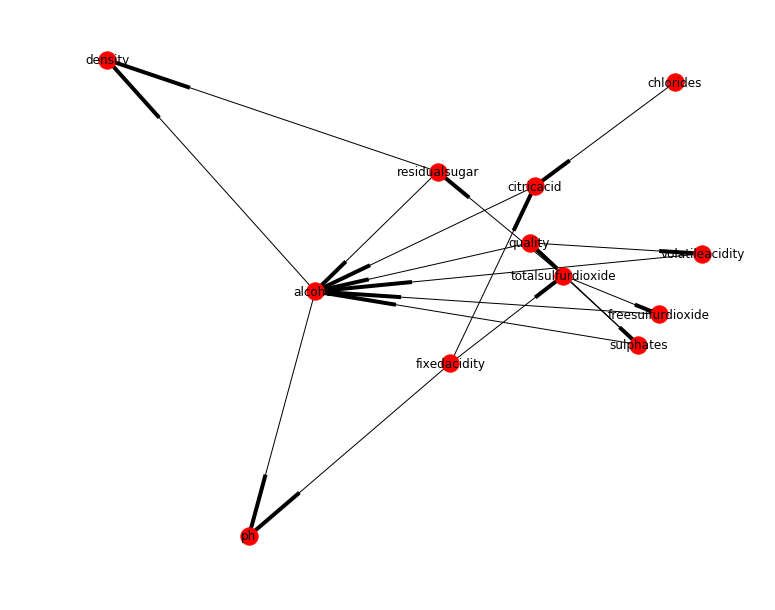

In [42]:
mediumDf = pandas.read_csv('medium.csv')
mg = initialize(mediumDf)
print(bayes_score(mg, mediumDf))

omg, best_score = local_search(mg, mediumDf, plimit=6)

print(best_score)
print(bayes_score(omg, mediumDf))

nx.draw(omg, with_labels=True)
plt.show()

-45388.95843
-42276.51187
-42276.51187


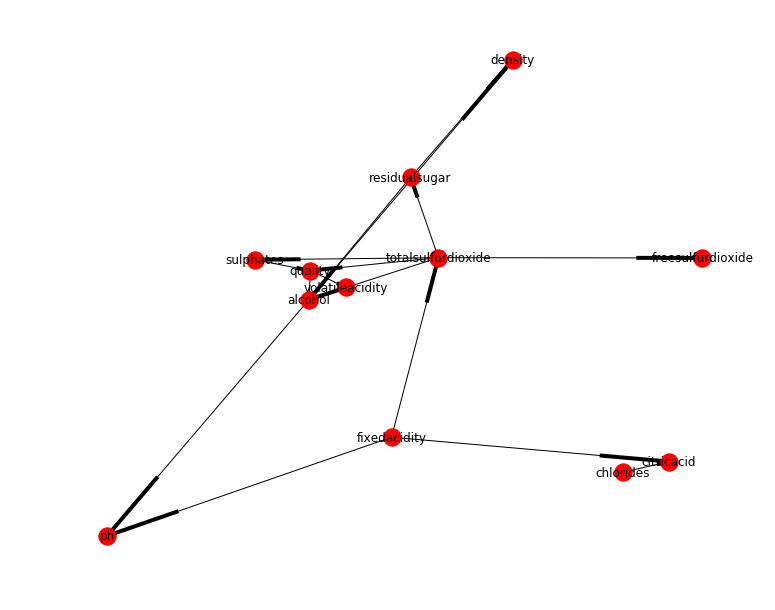

In [44]:
mediumDf = pandas.read_csv('medium.csv')
mg = initialize(mediumDf)
print(bayes_score(mg, mediumDf))

omg, best_score = local_search(mg, mediumDf, plimit=1000)

print(best_score)
print(bayes_score(omg, mediumDf))

nx.draw(omg, with_labels=True)
plt.show()

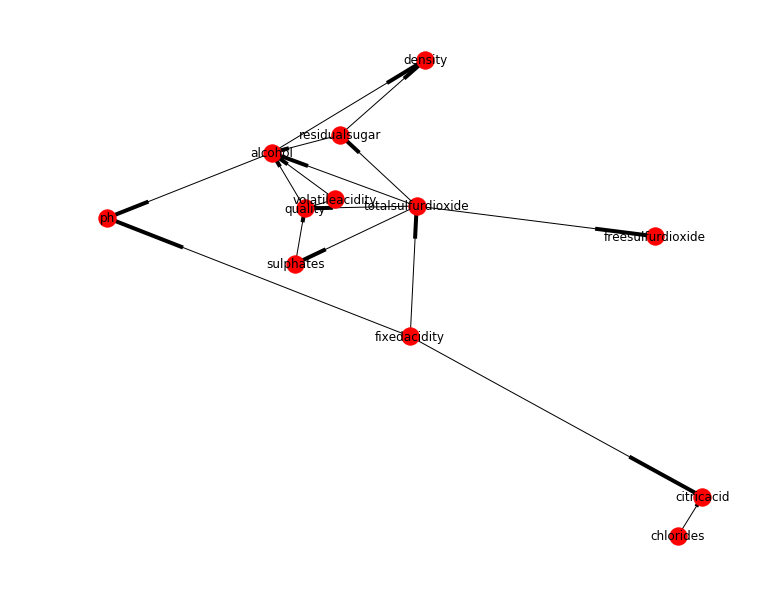

In [46]:
nx.draw(omg, with_labels=True)
plt.show()

-317497.0892
-262823.15315
-262823.15315


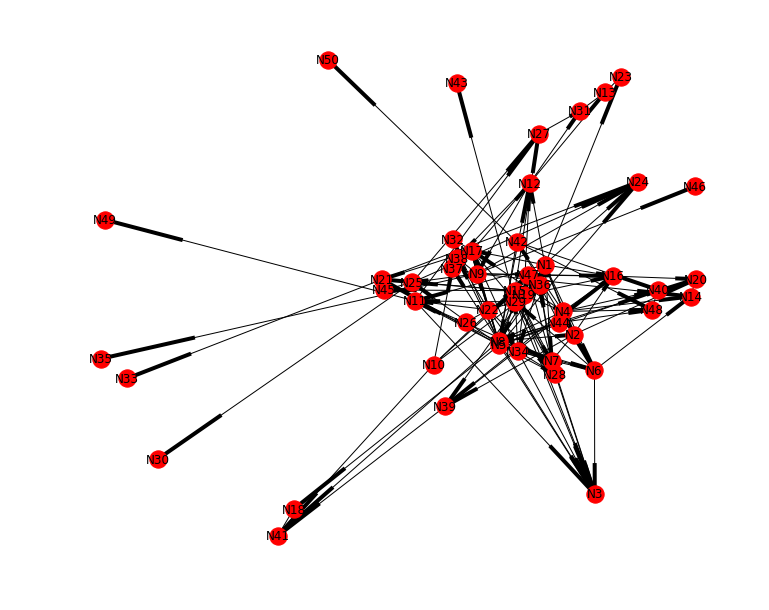

In [43]:
largeDf = pandas.read_csv('large.csv')
lg = initialize(largeDf)
print(bayes_score(lg, largeDf))

olg, best_score = local_search(lg, largeDf, plimit=1000)

print(best_score)
print(bayes_score(olg, largeDf))

nx.draw(olg, with_labels=True)
plt.show()

In [47]:
write_gph(olg, "large.gph")

In [48]:
write_gph(omg, "medium.gph")

In [49]:
write_gph(osg, "small.gph")

In [181]:
g = initialize(smallDf)

g.add_edge('numsiblings','numparentschildren')
g.add_edge('numsiblings','passengerclass')
g.add_edge('numparentschildren','sex')

print(score(g, smallDf))

-4106.483423833117


In [41]:
best_plimit = 0
best_score = -10000000
mtg = initialize(mediumDf)

for i in range(20):
    _, score = local_search(mtg, mediumDf, 1, i)
    if (score > best_score):
        best_score = score
        best_plimit = i

print(best_plimit)
print(best_score)

6
-42653.22442
